# TCLab PCR Prototype Version 0

## Integrating Feedforward and Feedback Control

TCLab version 0.4.9
Simulated TCLab


<IPython.core.display.Javascript object>


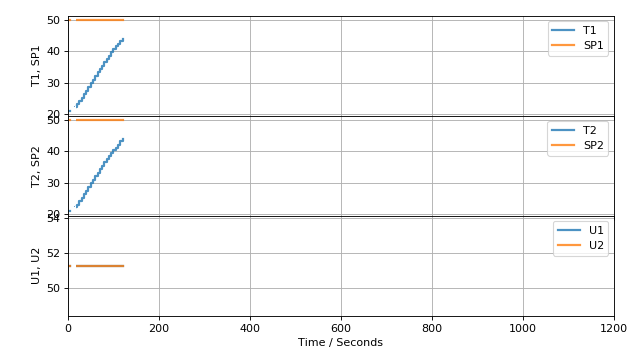

Data saved to data_20201512T101543.csv
TCLab Model disconnected successfully.


In [28]:
%matplotlib notebook

from IPython.display import display
import ipywidgets as widgets
import tclab
import threading
import datetime

# parameter values
Ua = 0.0250
Ub = 0.0105
Ta = 22

def feedforward(SP1, SP2, Ta):
    Q1 = Ua*(SP1 - Ta) + Ub*(SP1 - SP2)
    Q2 = Ua*(SP2 - Ta) + Ub*(SP2 - SP1)
    return [Q1, Q2]

def relay(MV_hi, MV_lo=0, h=1):
    MV = (MV_hi + MV_lo)/2
    while True:  
        SP, PV = yield MV      
        MV_prev = MV
        MV = MV_hi if PV < (SP - h) else MV_lo if PV > (SP + h) else MV_prev

TCLab = tclab.setup(connected=False, speedup=5)

def work(stop, setpoint1, setpoint2):
    with TCLab() as lab:
        
        # pre-run
        lab.P1 = 255
        lab.P2 = 255
        sources = [
            ('T1', lambda: lab.T1),
            ('T2', lambda: lab.T2),
            ('U1', lambda: lab.U1),
            ('U2', lambda: lab.U2),
            ('SP1', lambda: setpoint1.value),
            ('SP2', lambda: setpoint2.value)
        ]
        h = tclab.Historian(sources)
        p = tclab.Plotter(h, 1200, layout=(('T1', 'SP1'), ('T2', 'SP2'),('U1','U2')))
        feedback1 = relay(1, -1)
        _ = feedback1.send(None)
        feedback2 = relay(1, -1)
        _ = feedback2.send(None)
        
        # run
        for t in tclab.clock(10000, 5):
            Q1_ff, Q2_ff = feedforward(setpoint1.value, setpoint2.value, Ta)
            Q1_fb = feedback1.send([setpoint1.value, lab.T1])
            Q2_fb = feedback2.send([setpoint2.value, lab.T2])
            lab.U1 = max(0, min(100, 100*(Q1_ff + Q1_fb)/lab.P1/0.013))
            lab.U2 = max(0, min(100, 100*(Q2_ff + Q2_fb)/lab.P2/0.013))
            p.update(t)
            if stop.value:
                break
                
        # post-run
        fname = datetime.datetime.now().strftime("data_%Y%M%dT%H%M%S.csv")
        h.to_csv(fname)
        print("Data saved to", fname)

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
setpoint1 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 1")
setpoint2 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 2")

# thread
thread = threading.Thread(target=work, args=(stop, setpoint1, setpoint2))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(widgets.HBox([start, stop]))
display(widgets.HBox([setpoint1, setpoint2]))

## Steady State Control with Constraints

In [32]:
import numpy as np
import scipy.optimize

# decision variables Q1, Q2, T1, T2, z1p, z1m, z2p, z2m

Q_ps = 10
Q1_max = 3.3
Q2_max = 3.3
T_ub = 100

def mpc_ss(SP1, SP2, Ta=20):
    c = np.array([0, 0, 0, 0, 1, 1, 1, 1])
    A_ub = np.array([
        [1, 1, 0, 0, 0, 0, 0, 0]
    ])
    b_ub = np.array([Q_ps])
    A_eq = np.array([
        [-1, 0, (Ua + Ub), -Ub, 0, 0, 0, 0],
        [0, -1, -Ub, (Ua + Ub), 0, 0, 0, 0],
        [0, 0, 1, 0, -1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, -1, 1]
    ])
    b_eq = np.array([Ua*Ta, Ua*Ta, SP1, SP2])
    bounds = [(0, Q1_max), (0, Q2_max), (Ta, T_ub), (Ta, T_ub), (0, None), (0, None), (0, None), (0, None)]
    results = scipy.optimize.linprog(c, A_ub, b_ub, A_eq, b_eq, bounds)
    Q1, Q2, T1, T2, _, _, _, _ = results.x
    return [Q1, Q2, T1, T2]

Q1, Q2, T1, T2 = mpc_ss(103, 56)

TCLab version 0.4.9
Simulated TCLab


<IPython.core.display.Javascript object>


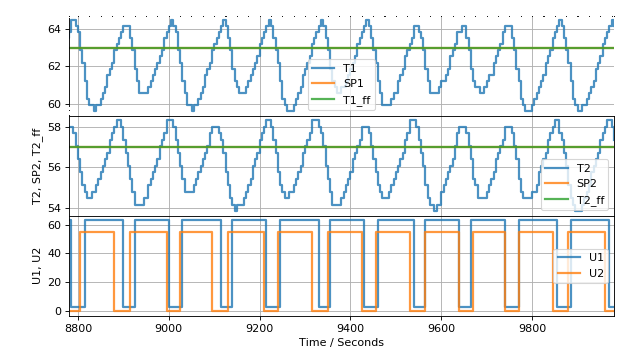

In [34]:
%matplotlib notebook

from IPython.display import display
import ipywidgets as widgets
import tclab
import threading
import datetime

# parameter values
Ua = 0.0250
Ub = 0.0105
Ta = 22

def feedforward(SP1, SP2, Ta):
    Q1 = Ua*(SP1 - Ta) + Ub*(SP1 - SP2)
    Q2 = Ua*(SP2 - Ta) + Ub*(SP2 - SP1)
    return [Q1, Q2]

def relay(MV_hi, MV_lo=0, h=1):
    MV = (MV_hi + MV_lo)/2
    while True:  
        SP, PV = yield MV      
        MV_prev = MV
        MV = MV_hi if PV < (SP - h) else MV_lo if PV > (SP + h) else MV_prev

TCLab = tclab.setup(connected=False, speedup=5)

def work(stop, setpoint1, setpoint2):
    with TCLab() as lab:
        
        # pre-run
        lab.P1 = 255
        lab.P2 = 255
        sources = [
            ('T1', lambda: lab.T1),
            ('T2', lambda: lab.T2),
            ('U1', lambda: lab.U1),
            ('U2', lambda: lab.U2),
            ('SP1', lambda: setpoint1.value),
            ('SP2', lambda: setpoint2.value),
            ('T1_ff', lambda: T1_ff),
            ('T2_ff', lambda: T2_ff)
        ]
        h = tclab.Historian(sources)
        p = tclab.Plotter(h, 1200, layout=(('T1', 'SP1', 'T1_ff'), ('T2', 'SP2','T2_ff'),('U1','U2')))
        feedback1 = relay(1, -1)
        _ = feedback1.send(None)
        feedback2 = relay(1, -1)
        _ = feedback2.send(None)
        
        # run
        for t in tclab.clock(10000, 5):
            Q1_ff, Q2_ff, T1_ff, T2_ff = mpc_ss(setpoint1.value, setpoint2.value, Ta)
            Q1_fb = feedback1.send([T1_ff, lab.T1])
            Q2_fb = feedback2.send([T2_ff, lab.T2])
            lab.U1 = max(0, min(100, 100*(Q1_ff + Q1_fb)/lab.P1/0.013))
            lab.U2 = max(0, min(100, 100*(Q2_ff + Q2_fb)/lab.P2/0.013))
            p.update(t)
            if stop.value:
                break
                
        # post-run
        fname = datetime.datetime.now().strftime("data_%Y%M%dT%H%M%S.csv")
        h.to_csv(fname)
        print("Data saved to", fname)

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
setpoint1 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 1")
setpoint2 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 2")

# thread
thread = threading.Thread(target=work, args=(stop, setpoint1, setpoint2))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(widgets.HBox([start, stop]))
display(widgets.HBox([setpoint1, setpoint2]))

## For Improved Performance we will need MPC